This based off of the tutorial from scanpy using pbmc 3K.
https://scanpy-tutorials.readthedocs.io/en/latest/pbmc3k.html

And heavily influenced by https://github.com/theislab/scanpy_usage/blob/master/170503_zheng17/zheng17.ipynb

We are interested in understanding the changes in the synovium due to Tocilizumab treatment. 
This notebook is the QC analysis for the bulk data from Rivellese, F. et al. Rituximab versus tocilizumab in rheumatoid arthritis: synovial biopsy-based biomarker analysis of the phase 4 R4RA randomized trial. Nat. Med. 28, 1256–1268 (2022).

This will be used with single-cell untreated synovium data from Zhang, F. et al. Deconstruction of rheumatoid arthritis synovium defines inflammatory subtypes. Nature 623, 616–624 (2023).
DOI:10.1038/s41586-023-06708-y, to infer the cell-type specific treatment effects.

In [55]:
import numpy as np
import pandas as pd
import scanpy as sc
import anndata as ad
from matplotlib.pyplot import rc_context

from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats

import os

sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')


scanpy==1.8.2 anndata==0.8.0 umap==0.5.2 numpy==1.23.5 scipy==1.8.1 pandas==1.5.3 scikit-learn==1.3.1 statsmodels==0.14.0 python-igraph==0.10.8 pynndescent==0.5.10


## Open files

In [56]:
data_path = f"{os.getcwd()}/../../data/bulk_data/synovium/"

#curr_treatment = "Rituximab"
curr_treatment = "Tocilizumab"
curr_treatment = "Rituximab_Tocilizumab"
# file downloaded from SeuratData then converted to h5ad 



in_file = f"{data_path}/synovium_bulk.h5ad"
results_file = f"{data_path}/synovium_bulk_processed_{curr_treatment}.h5ad"
de_results_file = f"{data_path}/synovium_bulk_de.pkl"

with open(in_file) as your_data:
    adata = sc.read_h5ad(in_file)

adata


AnnData object with n_obs × n_vars = 184 × 24569
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'pred_CTAP', 'sample_name', 'ena_sample', 'biosd_sample', 'sample_id', 'organism', 'individual', 'tissue_part', 'disease', 'clinical_history', 'age', 'unit_time', 'term_source_ref', 'term_accession_number', 'sex', 'ethnic_group', 'visit', 'unit_time_1', 'term_source_ref_1', 'term_accession_number_1', 'rheumatoid_factor_measurement', 'ccp_measurement', 'tender_joints_count', 'unit_count_unit', 'term_source_ref_2', 'term_accession_number_2', 'swollen_joints_count', 'unit_count_unit_1', 'term_source_ref_3', 'term_accession_number_3', 'arthritis_disease_activity_score', 'esr', 'unit_length_unit', 'term_source_ref_4', 'term_accession_number_4', 'crp', 'unit_concentration_unit', 'term_source_ref_5', 'term_accession_number_5', 'physician_global_assessment', 'cdai_response_status', 'bcell_class', 'pathotype', 'imputed_log_crp1', 'imputed_log_esr', 'imputed_tj_sqrt', 'imputed_sj_sqrt', 'imputed

In [57]:
adata.var_names_make_unique()  # this is unnecessary if using `var_names='gene_ids'` in `sc.read_10x_mtx`

# remove non-gene IDs
gene_idx = np.where(np.logical_not(adata.var_names.str.startswith('__')))[0]
adata = adata[:, gene_idx]



In [58]:
adata.var_names[np.where(adata.var_names.str.startswith('__'))]

Index([], dtype='object')

In [59]:
# how many of each mouse
tab = adata.obs.groupby(['sampling_time_point', 'sex']).size()

tab.unstack()

sex,female,male
sampling_time_point,,
0,109,24
16,43,8


In [60]:
# how many of each mouse
tab = adata.obs.groupby(['sampling_time_point', 'treatment']).size()

tab.unstack()

treatment,Rituximab,Tocilizumab
sampling_time_point,,
0,68,65
16,33,18


In [61]:
# how many of each mouse
tab = adata[np.where(adata.obs.treatment == "Tocilizumab")[0]].obs.groupby(['sampling_time_point', 'cdai_response_status']).size()

tab.unstack()

cdai_response_status,Non.Responder,Responder
sampling_time_point,,
0,28,37
16,12,6


In [62]:
# how many of each mouse
tab = adata[np.where(adata.obs.treatment == "Rituximab")[0]].obs.groupby(['sampling_time_point', 'cdai_response_status']).size()

tab.unstack()

cdai_response_status,Non.Responder,Responder
sampling_time_point,,
0,39,29
16,21,12


In [63]:

# subset to treatments and responders
#adata = adata[np.where(adata.obs["treatment"] == curr_treatment)]

# format sample name
adata.obs['sample_id'] = adata.obs.index.str[:12]


adata.obs

/var/folders/64/dljh4z4j4vq9yn4f7wkb2k1h0000gp/T/ipykernel_46536/1622769236.py:5: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['sample_id'] = adata.obs.index.str[:12]


,orig.ident,nCount_RNA,nFeature_RNA,pred_CTAP,sample_name,ena_sample,biosd_sample,sample_id,organism,individual,...,ena_run,fastq_url,sampling_time_point,unit_time_unit_2,term_source_ref_6,term_accession_number_6,entropy,CV1,CV2,treatment
R4RAPAT00002-week0,0,33092230.0,22623,0,Sample 1,ERS11589556,SAMEA13989176,R4RAPAT00002,Homo sapiens,R4RAPAT00002,...,ERR9539213,ftp://ftp.sra.ebi.ac.uk/vol1/fastq/ERR953/003/...,0,week,EFO,UO_0000034,0.950271,0.337867,-0.181978,Tocilizumab
R4RAPAT00013-week0,0,34079591.0,20636,2,Sample 10,ERS11589557,SAMEA13989177,R4RAPAT00013,Homo sapiens,R4RAPAT00013,...,ERR9539214,ftp://ftp.sra.ebi.ac.uk/vol1/fastq/ERR953/004/...,0,week,EFO,UO_0000034,0.673012,-0.678607,0.191517,Rituximab
R4RAPAT00094-week16,0,27063594.0,22532,4,Sample 100,ERS11589558,SAMEA13989178,R4RAPAT00094,Homo sapiens,R4RAPAT00094,...,ERR9539215,ftp://ftp.sra.ebi.ac.uk/vol1/fastq/ERR953/005/...,16,week,EFO,UO_0000034,0.500402,0.186492,0.216549,Rituximab
R4RAPAT00095-week0,0,17119043.0,23105,5,Sample 101,ERS11589559,SAMEA13989179,R4RAPAT00095,Homo sapiens,R4RAPAT00095,...,ERR9539216,ftp://ftp.sra.ebi.ac.uk/vol1/fastq/ERR953/006/...,0,week,EFO,UO_0000034,0.500402,0.564162,0.061935,Tocilizumab
R4RAPAT00096-week0,0,14005488.0,23042,0,Sample 102,ERS11589560,SAMEA13989180,R4RAPAT00096,Homo sapiens,R4RAPAT00096,...,ERR9539217,ftp://ftp.sra.ebi.ac.uk/vol1/fastq/ERR953/007/...,0,week,EFO,UO_0000034,0.950271,0.151749,-0.133618,Tocilizumab
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
R4RAPAT00091-week16,0,32401360.0,22838,5,Sample 95,ERS11589737,SAMEA13989357,R4RAPAT00091,Homo sapiens,R4RAPAT00091,...,ERR9539392,ftp://ftp.sra.ebi.ac.uk/vol1/fastq/ERR953/002/...,16,week,EFO,UO_0000034,0.500402,0.328390,0.146113,Rituximab
R4RAPAT00092-week0,0,41784647.0,21493,1,Sample 96,ERS11589738,SAMEA13989358,R4RAPAT00092,Homo sapiens,R4RAPAT00092,...,ERR9539393,ftp://ftp.sra.ebi.ac.uk/vol1/fastq/ERR953/003/...,0,week,EFO,UO_0000034,0.673012,-0.609035,0.085273,Tocilizumab
R4RAPAT00093-week0,0,36312961.0,21204,1,Sample 97,ERS11589739,SAMEA13989359,R4RAPAT00093,Homo sapiens,R4RAPAT00093,...,ERR9539394,ftp://ftp.sra.ebi.ac.uk/vol1/fastq/ERR953/004/...,0,week,EFO,UO_0000034,0.673012,-0.749015,0.219309,Rituximab
R4RAPAT00093-week16,0,18487825.0,22784,5,Sample 98,ERS11589740,SAMEA13989360,R4RAPAT00093,Homo sapiens,R4RAPAT00093,...,ERR9539395,ftp://ftp.sra.ebi.ac.uk/vol1/fastq/ERR953/005/...,16,week,EFO,UO_0000034,-0.000000,0.294851,0.246668,Rituximab


In [64]:
# how many of each mouse
tab = adata.obs.groupby(['sample_id', 'bcell_class']).size()

tab.unstack()



bcell_class,Bpoor,Brich,GC,Unknown
sample_id,,,,
R4RAPAT00002,1.0,NaN,NaN,NaN
R4RAPAT00003,NaN,NaN,NaN,1.0
R4RAPAT00004,1.0,NaN,NaN,NaN
R4RAPAT00005,NaN,1.0,NaN,NaN
R4RAPAT00007,1.0,NaN,NaN,NaN
...,...,...,...,...
R4RAPAT00152,NaN,1.0,NaN,NaN
R4RAPAT00154,NaN,1.0,NaN,NaN
R4RAPAT00155,1.0,NaN,NaN,NaN


In [65]:
# how many of each mouse
tab = adata.obs.groupby(['cdai_response_status', 'sampling_time_point']).size()

tab.unstack()

sampling_time_point,0,16
cdai_response_status,,
Non.Responder,67,33
Responder,66,18


In [66]:


# how many of each sample
tab = adata.obs.groupby(['sample_id', 'sampling_time_point']).size()
tab.unstack()

sampling_time_point,0,16
sample_id,,
R4RAPAT00002,1.0,NaN
R4RAPAT00003,1.0,NaN
R4RAPAT00004,1.0,NaN
R4RAPAT00005,1.0,NaN
R4RAPAT00007,1.0,NaN
...,...,...
R4RAPAT00152,1.0,NaN
R4RAPAT00154,1.0,NaN
R4RAPAT00155,1.0,NaN


## format the obs for BuDDI

In [67]:

# Initialize empty column in cell metadata
# for stim vs ctrl


def get_stim_id(in_str):
    out_str = "STIM"
    if in_str == "0":
        out_str = "CTRL"
           
    return(out_str)

adata.obs['stim'] = [get_stim_id(str(x)) for x in adata.obs["sampling_time_point"].tolist()]
adata.var['gene_ids'] = adata.var.index.tolist()


In [68]:
# how many of each 
tab = adata.obs.groupby(['sample_id', 'stim']).size()
tab.unstack()

stim,CTRL,STIM
sample_id,,
R4RAPAT00002,1.0,NaN
R4RAPAT00003,1.0,NaN
R4RAPAT00004,1.0,NaN
R4RAPAT00005,1.0,NaN
R4RAPAT00007,1.0,NaN
...,...,...
R4RAPAT00152,1.0,NaN
R4RAPAT00154,1.0,NaN
R4RAPAT00155,1.0,NaN


In [69]:
# get samples with paired before and after
tab = adata.obs.groupby(['sample_id', 'stim']).size()
temp_tab = tab.unstack()
paired_samps = np.asarray(temp_tab.index[np.where(np.sum(np.asarray(tab.unstack()), axis=1) == 2)[0]])


#adata = adata[adata.obs["sample_id"].isin(paired_samps)]
adata.obs["paired_samp"] = "unpaired"
adata.obs.paired_samp.iloc[np.where(np.isin(adata.obs["sample_id"], paired_samps))[0]] = "paired"
tab = adata.obs.iloc[np.where(adata.obs.paired_samp == "paired")[0]].groupby(['sample_id', 'stim']).size()
tab.unstack()

/var/folders/64/dljh4z4j4vq9yn4f7wkb2k1h0000gp/T/ipykernel_46536/735783638.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata.obs.paired_samp.iloc[np.where(np.isin(adata.obs["sample_id"], paired_samps))[0]] = "paired"


stim,CTRL,STIM
sample_id,,
R4RAPAT00015,1,1
R4RAPAT00025,1,1
R4RAPAT00027,1,1
R4RAPAT00039,1,1
R4RAPAT00045,1,1
R4RAPAT00046,1,1
R4RAPAT00047,1,1
R4RAPAT00048,1,1
R4RAPAT00051,1,1


In [70]:
paired_samps

array(['R4RAPAT00015', 'R4RAPAT00025', 'R4RAPAT00027', 'R4RAPAT00039',
       'R4RAPAT00045', 'R4RAPAT00046', 'R4RAPAT00047', 'R4RAPAT00048',
       'R4RAPAT00051', 'R4RAPAT00053', 'R4RAPAT00056', 'R4RAPAT00060',
       'R4RAPAT00061', 'R4RAPAT00066', 'R4RAPAT00072', 'R4RAPAT00091',
       'R4RAPAT00093', 'R4RAPAT00094', 'R4RAPAT00097', 'R4RAPAT00099',
       'R4RAPAT00100', 'R4RAPAT00104', 'R4RAPAT00107', 'R4RAPAT00110',
       'R4RAPAT00111', 'R4RAPAT00113', 'R4RAPAT00114', 'R4RAPAT00116',
       'R4RAPAT00117', 'R4RAPAT00118', 'R4RAPAT00119', 'R4RAPAT00120',
       'R4RAPAT00121', 'R4RAPAT00122', 'R4RAPAT00124', 'R4RAPAT00126',
       'R4RAPAT00129', 'R4RAPAT00131', 'R4RAPAT00137', 'R4RAPAT00138',
       'R4RAPAT00139', 'R4RAPAT00140', 'R4RAPAT00142', 'R4RAPAT00144',
       'R4RAPAT00145'], dtype=object)

In [71]:

tab = adata.obs.groupby(['treatment', 'paired_samp']).size()
tab.unstack()

paired_samp,paired,unpaired
treatment,,
Rituximab,58,43
Tocilizumab,32,51


In [72]:
tab = adata.obs.groupby(['treatment', 'cdai_response_status']).size()
tab.unstack()

cdai_response_status,Non.Responder,Responder
treatment,,
Rituximab,60,41
Tocilizumab,40,43


In [73]:

tab = adata.obs.groupby(['sample_id', 'cdai_response_status']).size()
tab.unstack()

cdai_response_status,Non.Responder,Responder
sample_id,,
R4RAPAT00002,NaN,1.0
R4RAPAT00003,NaN,1.0
R4RAPAT00004,NaN,1.0
R4RAPAT00005,1.0,NaN
R4RAPAT00007,NaN,1.0
...,...,...
R4RAPAT00152,1.0,NaN
R4RAPAT00154,NaN,1.0
R4RAPAT00155,1.0,NaN


## Preprocessing

normalizing counts per cell
    finished (0:00:00)


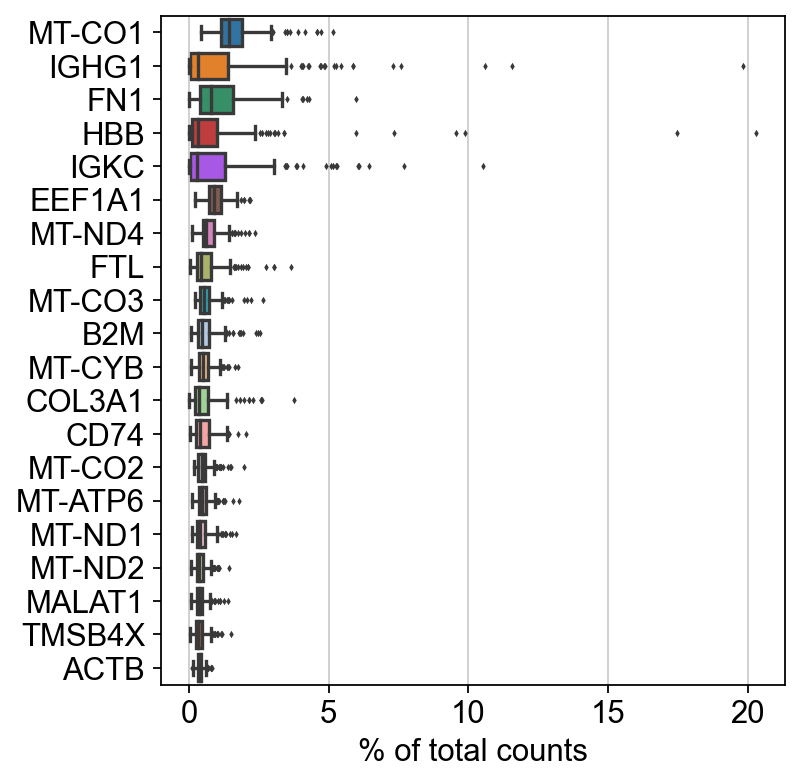

In [74]:
sc.pl.highest_expr_genes(adata, n_top=20, )


# DESeq

In [75]:
from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats

In [76]:
def get_DE(adata, meta_DESeq, curr_drug):
    meta_DESeq = adata.obs.copy()
    expr_matr = pd.DataFrame(adata.X.todense())

    expr_matr.index = adata.obs.sample_id
    expr_matr.columns = adata.var_names.to_list()


    # make it conform to DESeq reqr
    expr_matr = np.ceil(expr_matr)
    expr_matr = expr_matr+1

    # only compare with samples that have enough observations
    keep_idx = np.where(np.logical_and(adata.obs.paired_samp == "paired", adata.obs.treatment == curr_drug))[0]
    keep_samp_ids = adata.obs.sample_id[keep_idx].to_list()

    samp_idx = np.where(np.isin(meta_DESeq.sample_id, keep_samp_ids))[0]
    expr_matr = expr_matr.iloc[samp_idx,]
    meta_DESeq = meta_DESeq.iloc[samp_idx,]
    meta_DESeq.index = expr_matr.index

    # filter out lowly expressed genes
    genes_to_keep = expr_matr.columns[expr_matr.mean(axis=0) > 1]
    expr_matr = expr_matr[genes_to_keep]    
    print(expr_matr.shape)        

    # run deseq
    dds_cell = DeseqDataSet(
        counts=expr_matr,
        clinical=meta_DESeq,
        design_factors=["stim", "sample_id"],
        refit_cooks=True
    )

    print("running contrast")

    dds_cell.deseq2()
    cell_res = DeseqStats(dds_cell, contrast=["stim", "CTRL", "STIM"])
    cell_res.summary()

    # get the DESeq res matrix
    cell_res_df = cell_res.results_df

    # get the genes of interest
    cell_res_df_sig = cell_res_df.iloc[np.where(cell_res_df["padj"] < 0.01)[0]]
    cell_res_df_sig = cell_res_df_sig.iloc[np.argsort(np.abs(cell_res_df_sig["log2FoldChange"]))]
    top_genes = cell_res_df_sig.index.to_list()

    return (top_genes, cell_res_df) 

In [77]:
_, toc_res_df = get_DE(adata, adata.obs, curr_drug="Tocilizumab")
_, rit_res_df = get_DE(adata, adata.obs, curr_drug="Rituximab")

toc_res_df["drug"] = "toc"
rit_res_df["drug"] = "rit"

all_res_df = pd.concat([toc_res_df, rit_res_df])

(32, 24240)
running contrast
Fitting size factors...
... done in 0.03 seconds.



/Users/davidnat/Documents/projects/greenelab/buddi_test/.venv/lib/python3.10/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


Fitting dispersions...
... done in 5.39 seconds.

Fitting dispersion trend curve...
... done in 3.37 seconds.

Fitting MAP dispersions...
... done in 4.65 seconds.

Fitting LFCs...
... done in 2.30 seconds.

Refitting 9 outliers.



/Users/davidnat/Documents/projects/greenelab/buddi_test/.venv/lib/python3.10/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/Users/davidnat/Documents/projects/greenelab/buddi_test/.venv/lib/python3.10/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/Users/davidnat/Documents/projects/greenelab/buddi_test/.venv/lib/python3.10/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


Fitting dispersions...
... done in 0.01 seconds.

Fitting MAP dispersions...
... done in 0.01 seconds.

Fitting LFCs...
... done in 0.01 seconds.

Running Wald tests...
... done in 1.23 seconds.

Log2 fold change & Wald test p-value: stim CTRL vs STIM


,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
MIR1302-2HG,3.684570,-0.449728,0.375697,-1.197051,0.231287,NaN
FAM138A,3.982860,-0.482341,0.441824,-1.091703,0.274963,0.425225
OR4F5,1.896286,0.128772,0.509611,0.252686,0.800511,NaN
OR4F29,1.136942,0.618682,0.570521,1.084416,0.278180,NaN
LINC01409,76.775925,-0.205006,0.182014,-1.126321,0.260030,0.408824
...,...,...,...,...,...,...
MT-ND4,197526.784484,0.052098,0.181468,0.287090,0.774044,0.855619
MT-ND5,86710.399573,-0.134258,0.219298,-0.612215,0.540396,0.674917
MT-ND6,49435.182062,0.136521,0.172324,0.792239,0.428222,0.577629
MT-CYB,147027.963073,0.075962,0.177200,0.428682,0.668155,0.779139


(58, 24313)


/Users/davidnat/Documents/projects/greenelab/buddi_test/.venv/lib/python3.10/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


running contrast
Fitting size factors...
... done in 0.05 seconds.

Fitting dispersions...
... done in 9.49 seconds.

Fitting dispersion trend curve...
... done in 3.18 seconds.

Fitting MAP dispersions...
... done in 6.78 seconds.

Fitting LFCs...
... done in 2.88 seconds.



/Users/davidnat/Documents/projects/greenelab/buddi_test/.venv/lib/python3.10/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


Refitting 0 outliers.

Running Wald tests...
... done in 1.06 seconds.

Log2 fold change & Wald test p-value: stim CTRL vs STIM


,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
MIR1302-2HG,3.030199,-0.329575,0.296685,-1.110859,0.266629,0.369077
FAM138A,3.913763,-0.409473,0.314282,-1.302883,0.192615,0.287497
OR4F5,1.964382,-0.506407,0.337314,-1.501293,0.133280,NaN
OR4F29,1.124703,0.068691,0.397940,0.172617,0.862953,NaN
LINC01409,77.003600,-0.136699,0.130184,-1.050049,0.293696,0.397203
...,...,...,...,...,...,...
MT-ND4,172678.945429,-0.005175,0.127241,-0.040674,0.967556,0.977330
MT-ND5,77486.287176,0.004084,0.153039,0.026685,0.978711,0.984731
MT-ND6,44382.611930,0.063950,0.132829,0.481448,0.630198,0.711203
MT-CYB,124867.092459,-0.064125,0.123693,-0.518422,0.604164,0.688406


In [78]:
all_res_df

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,drug
MIR1302-2HG,3.684570,-0.449728,0.375697,-1.197051,0.231287,NaN,toc
FAM138A,3.982860,-0.482341,0.441824,-1.091703,0.274963,0.425225,toc
OR4F5,1.896286,0.128772,0.509611,0.252686,0.800511,NaN,toc
OR4F29,1.136942,0.618682,0.570521,1.084416,0.278180,NaN,toc
LINC01409,76.775925,-0.205006,0.182014,-1.126321,0.260030,0.408824,toc
...,...,...,...,...,...,...,...
MT-ND4,172678.945429,-0.005175,0.127241,-0.040674,0.967556,0.977330,rit
MT-ND5,77486.287176,0.004084,0.153039,0.026685,0.978711,0.984731,rit
MT-ND6,44382.611930,0.063950,0.132829,0.481448,0.630198,0.711203,rit
MT-CYB,124867.092459,-0.064125,0.123693,-0.518422,0.604164,0.688406,rit


In [79]:
import pickle

print("write")        

pickle.dump( all_res_df, open( de_results_file, "wb" ) )

write


# Write + Plot data

In [21]:
results_file

'/Users/davidnat/Documents/projects/greenelab/buddi_test/buddi_analysis/sc_preprocessing/0_qc_notebooks/../../data/bulk_data/synovium//synovium_bulk_processed_Rituximab_Tocilizumab.h5ad'

In [22]:
# write it out before normalization
del adata.raw
adata.write(results_file)


extracting highly variable genes


    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


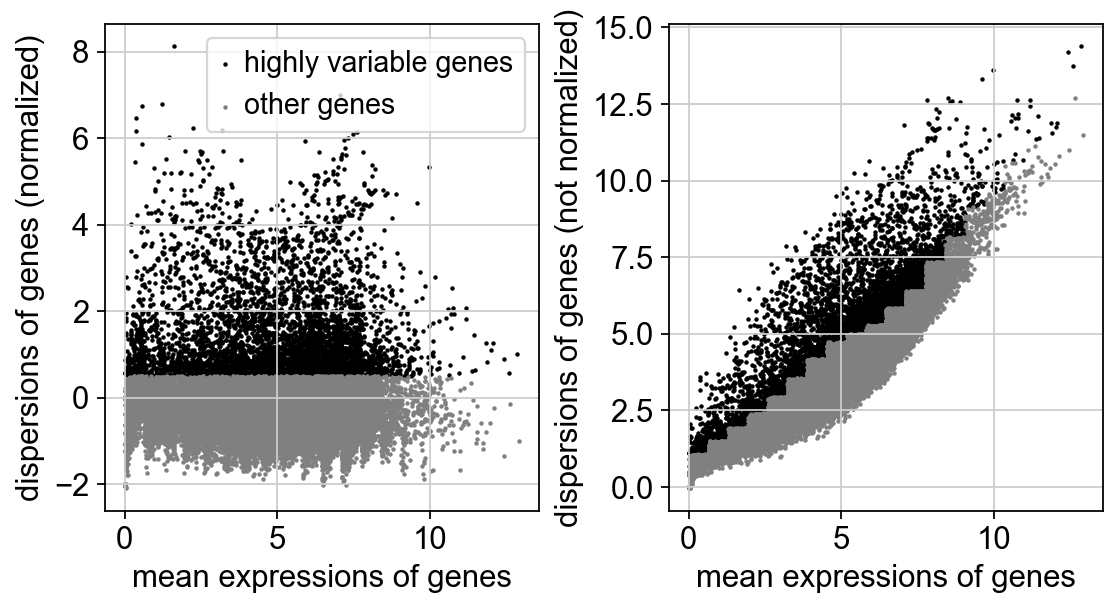

In [23]:

# log data
sc.pp.log1p(adata)

# get high variance genes
sc.pp.highly_variable_genes(adata, min_mean=0, max_mean=15, min_disp=0.5)

# and plot
sc.pl.highly_variable_genes(adata)



In [24]:
# now process the counts further for doing DE 
# analysis and the cell clustering
adata = adata[:, adata.var.highly_variable]

# scale the genes
sc.pp.scale(adata, max_value=20)

... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


/Users/davidnat/Documents/projects/greenelab/buddi_test/.venv/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


## PCA

In [25]:
sc.tl.pca(adata, n_comps=20)
sc.pp.neighbors(adata)


computing PCA
    on highly variable genes
    with n_comps=20
    finished (0:00:00)
computing neighbors
    using 'X_pca' with n_pcs = 20
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:01)


/Users/davidnat/Documents/projects/greenelab/buddi_test/.venv/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:378: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


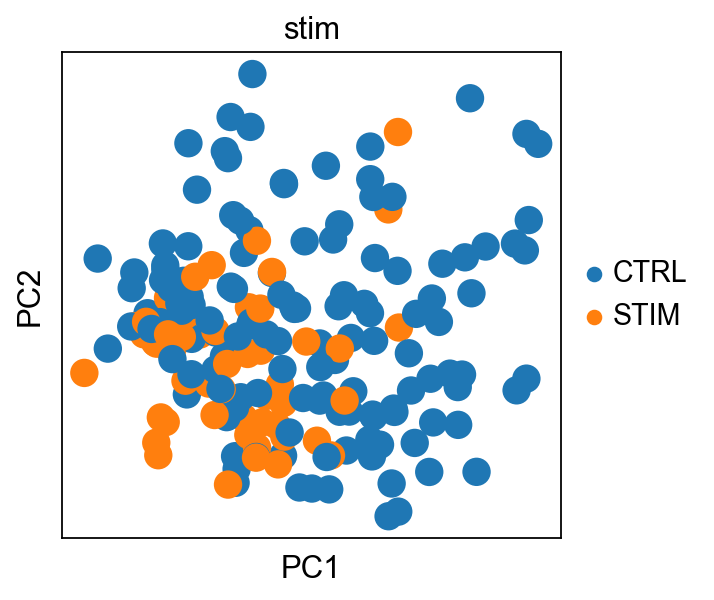

In [26]:
sc.pl.pca(adata, color="stim")

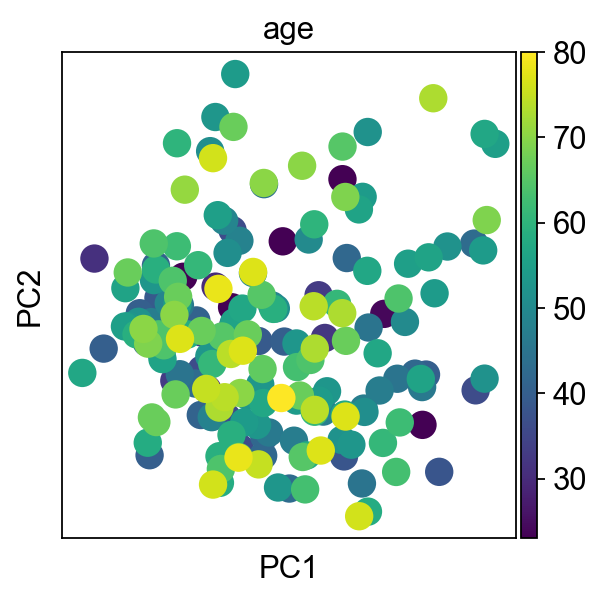

In [27]:
sc.pl.pca(adata, color="age")

/Users/davidnat/Documents/projects/greenelab/buddi_test/.venv/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:378: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


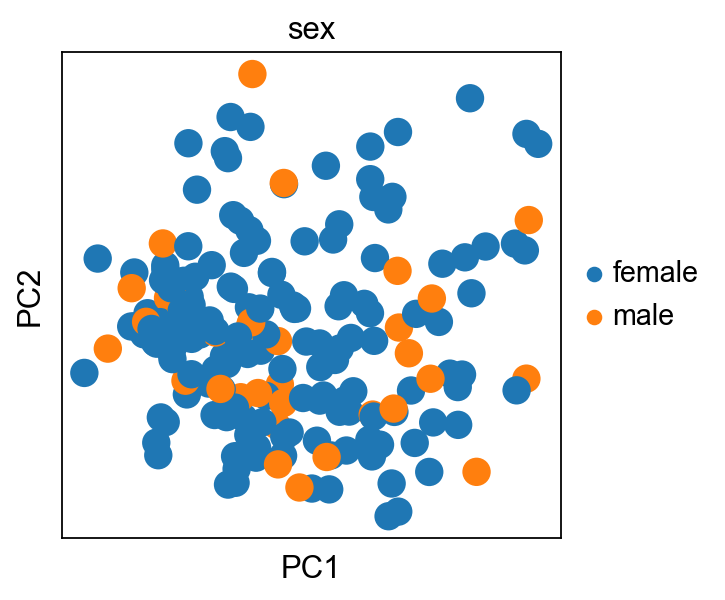

In [28]:
sc.pl.pca(adata, color="sex")

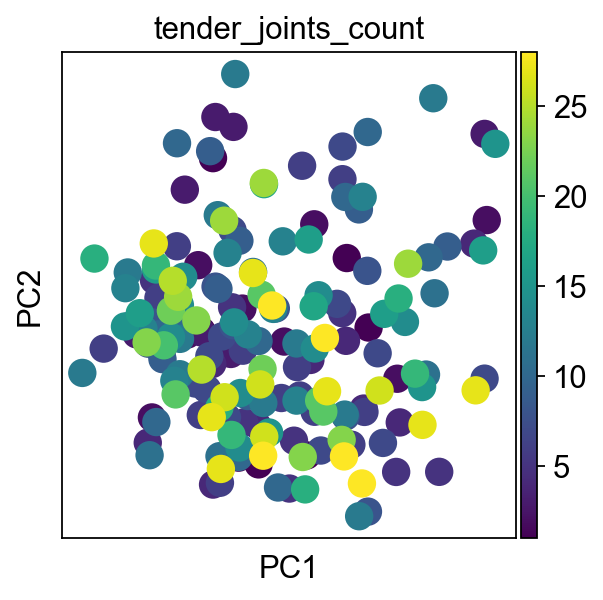

In [29]:
sc.pl.pca(adata, color="tender_joints_count")

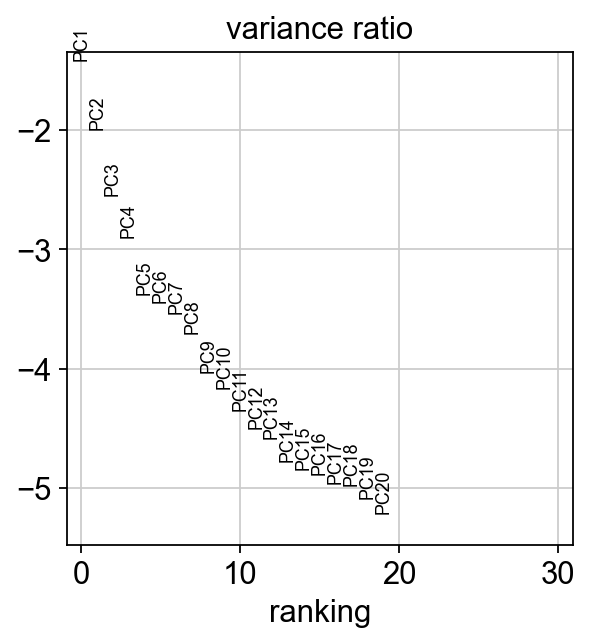

In [30]:
sc.pl.pca_variance_ratio(adata, log=True)



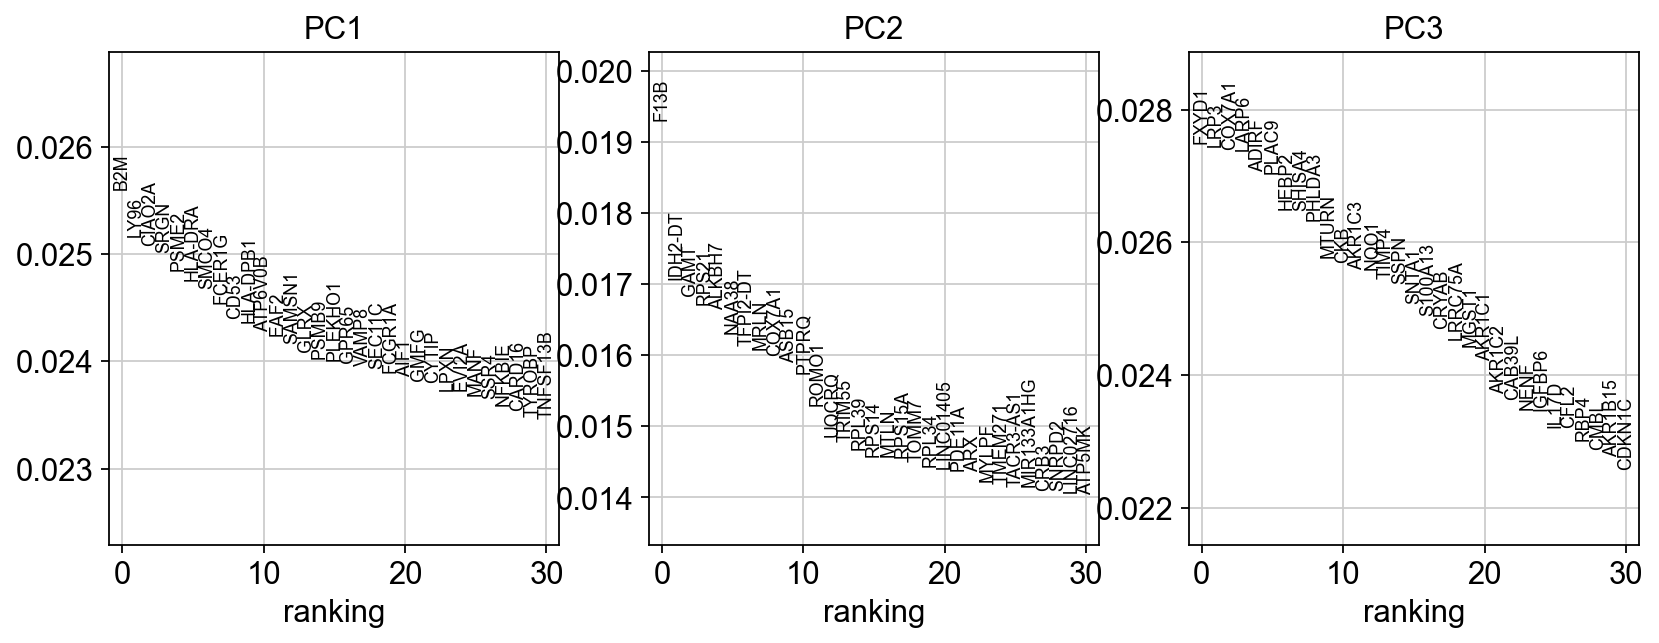

In [31]:
sc.pl.pca_loadings(adata, include_lowest=False)
